# Dynamics of AsymMixers

In this notebook we provide a demo for the dynamics of continuous *AsymMixer*, introduced in Section 6 of the paper "Hierarchical Associative Memory, Parallelized MLP-Mixer, and Symmetry Breaking," [arXiv:2406.12220](https://arxiv.org/abs/2406.12220), by numerically solving the differential eqs using the `torchdiffeq` (https://github.com/rtqichen/torchdiffeq) framework.

For more details, see Sections 6.1 and 6.2 of the paper.

In [ ]:
!pip install torchdiffeq

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchdiffeq import odeint


seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## AsymMixer

The model is given by the Lagrangians

\begin{align}
  L_v(x^v) &= \sqrt{ \sum_{i,I} (x^v_{iI} - \bar{v})^2},  \quad  \bar{v} =\frac{1}{N_v} \sum_{i,I} x^v_{iI} \\
  L_s(x^s) &= \sum_{\alpha=1}^{N_s} \Phi_{\text{GELU}}(x^s_\alpha),  \quad  L_c(x^c) = \sum_{\beta=1}^{N_c} \Phi_{\text{GELU}}(x^c_\beta),
\end{align}

where $\Phi_{\text{GELU}}(x):=\frac14(x^2 + (x^2-1)\mathrm{erf}(x/\sqrt{2}) + x\sqrt{2/\pi}e^{-x^2/2})$ and its derivative gives $\Phi_{\text{GELU}}'(x)=\mathrm{GELU}(x)$.


From these Lagrangians with the adiabatic limit $\tau_v \gg \tau_s, \tau_c$, one obtains the dynamical equation:

\begin{align}
  \frac{dx^v_{iI}(t)}{dt}
    &= \sum_{\alpha=1}^{N_s} \xi^{(v,s)}_{iI\alpha} \mathrm{GELU}\left( \sum_{i,I} \xi^{(s,v)}_{\alpha iI} \mathrm{LN}(x^v(t))_{iI} \right)  
     + \sum_{\beta=1}^{N_c} \xi^{(v,c)}_{iI\beta} \mathrm{GELU}\left( \sum_{i,I} \xi^{(c,v)}_{\beta iI} \mathrm{LN}(x^v(t))_{iI} \right)  
     - x^v_{iI}(t),  \\
    &\simeq \sum_{\alpha=1}^{N_s} \xi^{(v,s)}_{i\alpha} \mathrm{GELU}\left( \sum_{i=1}^{N_{v_s}} \xi^{(s,v)}_{\alpha i} \mathrm{LN}(x^v(t))_{iI} \right)  
     + \sum_{\beta=1}^{N_c} \xi^{(v,c)}_{I\beta} \mathrm{GELU}\left( \sum_{I=1}^{N_{v_c}} \xi^{(c,v)}_{\beta I} \mathrm{LN}(x^v(t))_{iI} \right)  
     - x^v_{iI}(t),
\end{align}

where we take $\tau_s,\tau_c \to 0$, set $\tau_v=1$, and $\mathrm{LN}:=\mathrm{LayerNorm}$. The energy function is determined by this Lagrangians as

\begin{align}
  E(x^v)
    &= \sum_{i,I} x^v_{iI} \mathrm{LN}(x^v)_{iI} - \sqrt{\sum_{i,I} (x^v_{iI} - \bar{v})^2}  \\
    &\quad - \sum_{\alpha=1}^{N_s} \Phi_{\text{GELU}} (x^s_\alpha)
    + \frac12 \sum_{i,I} \mathrm{LN}(x^v)_{iI} \tilde{W}_{i\alpha} \mathrm{GELU}(x^s_\alpha) \\
    &\quad - \sum_{\beta=1}^{N_c} \Phi_{\text{GELU}} (x^c_\beta)
    + \frac12 \sum_{i,I} \mathrm{LN}(x^v)_{iI} \tilde{W}_{I\beta} \mathrm{GELU}(x^c_\beta),
\end{align}

where

\begin{align}
  x^s_\alpha
    = \sum_{i=1}^{N_{v_s}} W_{\alpha i}\left(\sum_{I=1}^{N_{v_c}} \mathrm{LN} (x^v)_{iI} \right),
  \quad
  x^c_\beta
    = \sum_{I=1}^{N_{v_c}} W_{\beta I}\left(\sum_{i=1}^{N_{v_s}} \mathrm{LN} (x^v)_{iI} \right),
\end{align}

and

\begin{align}
  W_{\alpha i}
    &= \xi^{(s,v)}_{\alpha i},
  \quad
  \tilde{W}_{i\alpha}
     = \xi^{(v,s)}_{i \alpha} - (\xi^{(s,v) \top})_{i \alpha},  \\
  W_{\beta I}
    &= \xi^{(c,v)}_{\beta I},
  \quad
  \tilde{W}_{I\beta}
    = \xi^{(v,c)}_{I \beta} - (\xi^{(c,v) \top})_{I \beta}.
\end{align}

In [ ]:
# asymmetric MLP
class aMlp(nn.Module):
    def __init__(
            self,
            weight1,
            weight2,
    ):
        super().__init__()
        self.weight1 = weight1.T  # shape: (S/C, Ns/Nc)
        self.act = F.gelu
        self.weight2 = weight2.T  # shape: (Ns/Nc, S/C)

    def forward(self, x):
        x = F.linear(x, self.weight1).sum(dim=-2, keepdim=True)
        x = self.act(x)
        x = F.linear(x, self.weight1.T) + F.linear(x, self.weight2)  #* symmetry breaking term
        return x

class pMixerBlock(nn.Module):
    def __init__(
            self,
            dim,
            seq_len,
            weight1s,
            weight2s,
            weight1c,
            weight2c,
            mlp_layer=aMlp,
    ):
        super().__init__()
        self.seq_len = seq_len
        self.dim = dim
        self.mlp_tokens = mlp_layer(weight1s, weight2s)
        self.mlp_channels = mlp_layer(weight1c, weight2c)

    # parallelized feedforward MLPs
    def forward(self, x):
        x_norm = F.layer_norm(x, normalized_shape=(x.shape[-2], x.shape[-1]))
        x = self.mlp_tokens(x_norm.transpose(-1, -2)).transpose(-1, -2) + self.mlp_channels(x_norm) - x
        return x


def Lag_v(x):
    return torch.std(x, dim=(-1, -2), correction=x.shape[-1]*x.shape[-2] - 1)

def Ev(x, x_norm):
    return torch.sum(x * x_norm, dim=(-1, -2)) - Lag_v(x)

def LagGELU(x):
    PI = torch.Tensor([math.pi])
    sqrt2 = torch.sqrt(torch.Tensor([2]))
    x2 = torch.square(x)

    temp = x2
    temp += (x2 - 1) * torch.erf(x/sqrt2)
    temp += x * torch.sqrt(2/PI) * torch.exp(-x2/2)
    return temp/4

def Lag_h(x_norm, weight, dim):
    temp = torch.sum(x_norm, dim=dim)
    temp = F.linear(temp, weight)
    return torch.sum(LagGELU(temp), dim=-1)

def Eint(x_norm, weight, weight2, dim):  # interaction energy from asymmetric weights
    temp  = torch.sum(x_norm, dim=dim)
    temp_ = F.linear(temp, weight)
    temp_ = F.gelu(temp_)
    temp_ = F.linear(temp_, weight2)
    return torch.sum(temp * temp_, dim=-1)/2


# pseudo energy function incorporating symmetry breaking phase
def Easym(x, norm, Ws, Wc, Ws2, Wc2, dim_s=-1, dim_c=-2):  # shape of x = (B, S, C)
    x_norm = F.layer_norm(x, normalized_shape=(x.shape[-2], x.shape[-1]))
    temp = Ev(x, x_norm)
    temp += - Lag_h(x_norm, weight=Ws, dim=dim_s) + Eint(x_norm, weight=Ws, weight2=Ws2, dim=dim_s)
    temp += - Lag_h(x_norm, weight=Wc, dim=dim_c) + Eint(x_norm, weight=Wc, weight2=Wc2, dim=dim_c)
    return temp  # shape = (B,)



def _sample_spherical(npoints, ndim=3, radius=1.0):
    vec = torch.randn(ndim, npoints)
    vec /= torch.linalg.norm(vec, dim=0)
    return vec * radius

## NDSolve the dynamical eq.: simple example

### Symmetric case

In [ ]:
# sample weights

n_sample = 1

B = 10
S = 2; C = 1  # S=N_vs, C=N_vc
Ns = 3; Nc = 2

r_s1 = 0.2; r_c1 = 0.5
r_s2 = 0.0; r_c2 = 0.0  # turn off the symmetry-breaking terms

weight_s1 = _sample_spherical(npoints=n_sample, ndim=S*Ns, radius=r_s1).T.reshape(n_sample,S,Ns)
weight_c1 = _sample_spherical(npoints=n_sample, ndim=C*Nc, radius=r_c1).T.reshape(n_sample,C,Nc)

weight_s2 = _sample_spherical(npoints=n_sample, ndim=Ns*S, radius=r_s2).T.reshape(n_sample,Ns,S)
weight_c2 = _sample_spherical(npoints=n_sample, ndim=Nc*C, radius=r_c2).T.reshape(n_sample,Nc,C)

print(weight_s1, weight_s1.shape)  # (B, S, Ns)
print(weight_s2, weight_s2.shape)

tensor([[[ 0.0788,  0.1539,  0.0357],
         [ 0.0669,  0.0078, -0.0656]]]) torch.Size([1, 2, 3])
tensor([[[-0., 0.],
         [0., 0.],
         [-0., 0.]]]) torch.Size([1, 3, 2])


torch.Size([1000, 10, 2, 1])
torch.Size([1000, 2])


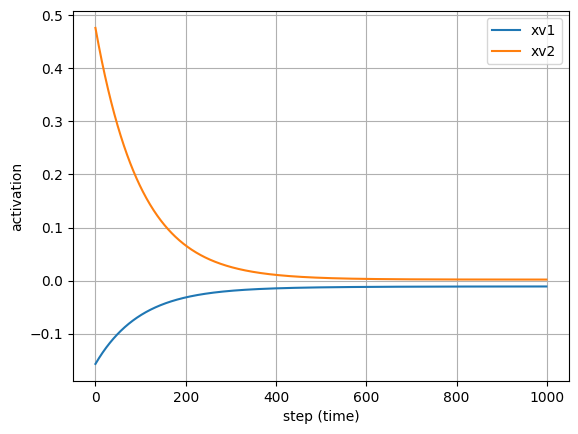

(xv1[t=-1], xv2[t=-1]) = tensor(-0.0110) tensor(0.0020)


In [ ]:
# solve the dynamical eq

mixerblock = pMixerBlock(seq_len=S,
                         dim=C,
                         weight1s=weight_s1[0],
                         weight2s=weight_s2[0],
                         weight1c=weight_c1[0],
                         weight2c=weight_c2[0],
                         )

def asymmixer(t, x):
    return mixerblock(x)


x0 = torch.normal(mean=0.5, std=0.5, size=(B, S, C))
t = torch.linspace(0,10,1000)
sol = odeint(asymmixer, x0, t)
print(sol.shape)  # (t, B, S, C)

out = sol[:, 0, :, 0]
print(out.shape)  # (t, S)


plt.plot(out[:, 0], label='xv1')
plt.plot(out[:, 1], label='xv2')
plt.xlabel("step (time)")
plt.ylabel("activation")
plt.grid()
plt.legend()
plt.show()

print('(xv1[t=-1], xv2[t=-1]) =', out[-1][0], out[-1][1])

torch.Size([1000, 10])


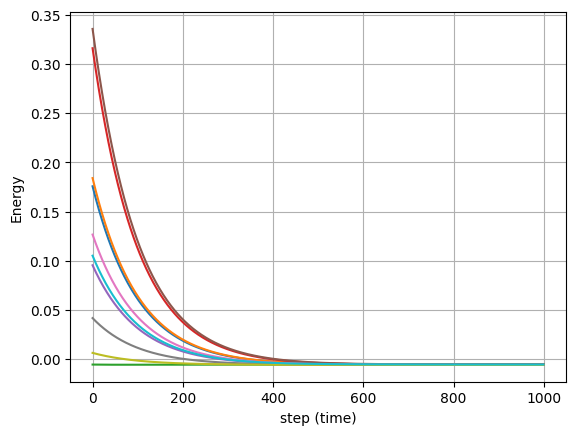

tensor([-0.0055, -0.0055, -0.0055, -0.0059, -0.0055, -0.0055, -0.0059, -0.0059,
        -0.0059, -0.0055])


In [ ]:
# plot energies along the trajectory

E_t = Easym(sol,
            norm=None,
            Ws=weight_s1[0].T,
            Wc=weight_c1[0].T,
            Ws2=weight_s2[0].T,
            Wc2=weight_c2[0].T,
            dim_s=-1,
            dim_c=-2,
            )
print(E_t.shape)  # (t, B)


for en in E_t.T:
    plt.plot(en)
plt.xlabel("step (time)")
plt.ylabel("Energy")
plt.grid()
plt.show()

print(E_t[-1])

(100, 100, 2, 1)
torch.Size([100, 100])


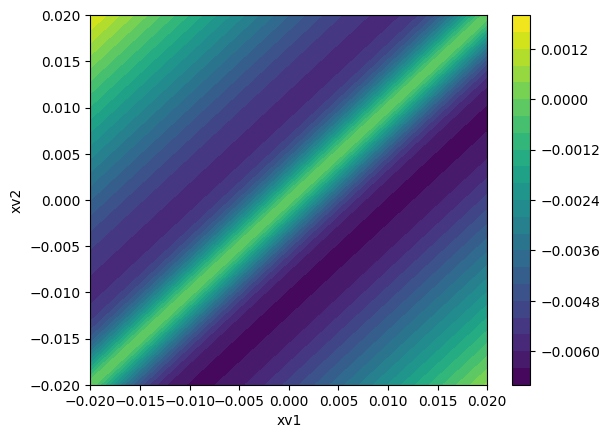

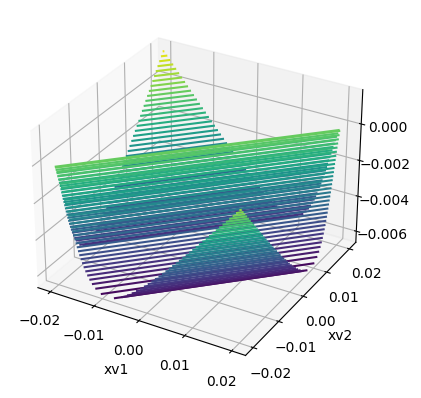

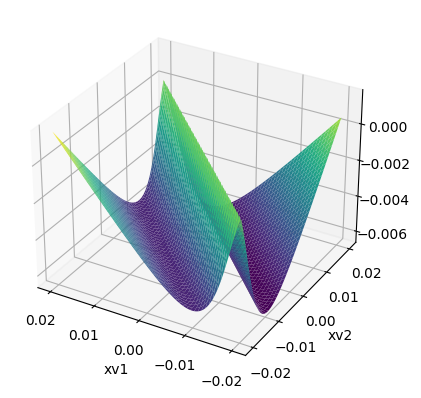

In [ ]:
# energy landscape

rng = 0.02
x = np.linspace(- rng, rng, 100)
y = np.linspace(- rng, rng, 100)
X, Y = np.meshgrid(x, y)

XY = np.concatenate([np.expand_dims(X, axis=-1), np.expand_dims(Y, axis=-1)], axis=-1)
XY = np.expand_dims(XY, axis=-1)
print(XY.shape)


En = Easym(torch.from_numpy(XY.astype(np.float32)).clone(),
          norm=None,
          Ws=weight_s1[0].T,
          Wc=weight_c1[0].T,
          Ws2=weight_s2[0].T,
          Wc2=weight_c2[0].T,
          dim_s=-1,
          dim_c=-2,
          )

print(En.shape)

#plt.contour(X, Y, En)
plt.contourf(X, Y, En, 20, cmap='viridis')
plt.colorbar()
plt.xlabel('xv1')
plt.ylabel('xv2')
plt.show()


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.contour3D(X, Y, En, 50, cmap='viridis')
ax.set_xlabel('xv1')
ax.set_ylabel('xv2')
plt.show()



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.invert_xaxis()
surf = ax.plot_surface(X, Y, En.T, cmap='viridis', linewidth=0)
ax.set_xlabel('xv1')
ax.set_ylabel('xv2')
fig.show()

### Asymmetric case

In [ ]:
# sample weights

n_sample = 1

B = 10
S = 2; C = 1  # S=N_vs, C=N_vc
Ns = 3; Nc = 2

r_s1 = 1.0; r_c1 = 2.5
r_s2 = 1.5; r_c2 = 4.0  # turn on the symmetry-breaking terms

weight_s1 = _sample_spherical(npoints=n_sample, ndim=S*Ns, radius=r_s1).T.reshape(n_sample,S,Ns)
weight_c1 = _sample_spherical(npoints=n_sample, ndim=C*Nc, radius=r_c1).T.reshape(n_sample,C,Nc)

weight_s2 = _sample_spherical(npoints=n_sample, ndim=Ns*S, radius=r_s2).T.reshape(n_sample,Ns,S)
weight_c2 = _sample_spherical(npoints=n_sample, ndim=Nc*C, radius=r_c2).T.reshape(n_sample,Nc,C)

print(weight_s1, weight_s1.shape)  # (B, S, Ns)
print(weight_s2, weight_s2.shape)

tensor([[[-0.0837,  0.2632,  0.2332],
         [-0.8637, -0.2746,  0.2190]]]) torch.Size([1, 2, 3])
tensor([[[ 0.2389, -0.8805],
         [ 1.0576, -0.0356],
         [-0.3305, -0.4343]]]) torch.Size([1, 3, 2])


torch.Size([1000, 10, 2, 1])
torch.Size([1000, 2])


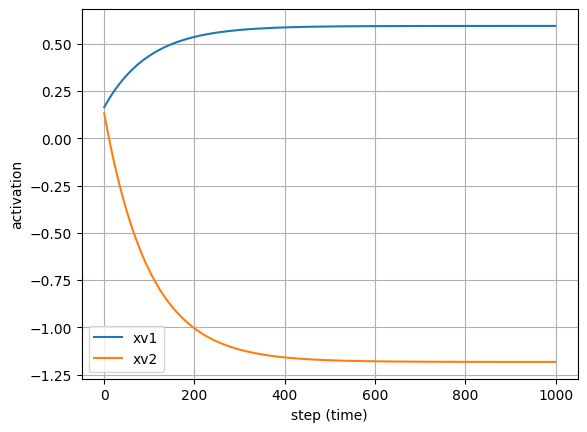

(xv1[t=-1], xv2[t=-1]) = tensor(0.5945) tensor(-1.1834)


In [ ]:
# solve the dynamical eq

mixerblock = pMixerBlock(seq_len=S,
                         dim=C,
                         weight1s=weight_s1[0],
                         weight2s=weight_s2[0],
                         weight1c=weight_c1[0],
                         weight2c=weight_c2[0],
                         )

def asymmixer(t, x):
    return mixerblock(x)


x0 = torch.normal(mean=0.5, std=0.5, size=(B, S, C))
t = torch.linspace(0,10,1000)
sol = odeint(asymmixer, x0, t)
print(sol.shape)  # (t, B, S, C)

out = sol[:, 0, :, 0]
print(out.shape)  # (t, S)


plt.plot(out[:, 0], label='xv1')
plt.plot(out[:, 1], label='xv2')
plt.xlabel("step (time)")
plt.ylabel("activation")
plt.grid()
plt.legend()
plt.show()

print('(xv1[t=-1], xv2[t=-1]) =', out[-1][0], out[-1][1])

torch.Size([1000, 10])


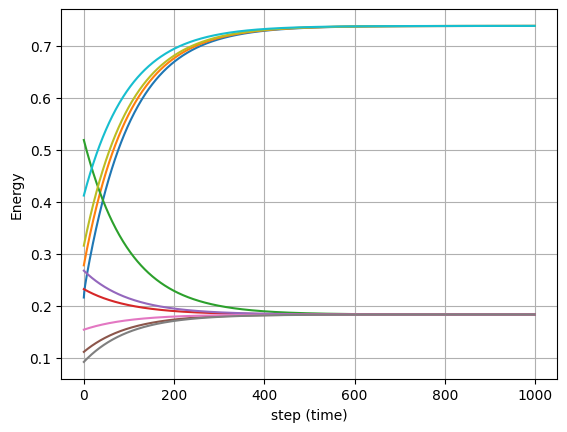

tensor([0.7377, 0.7377, 0.1833, 0.1833, 0.1833, 0.1833, 0.1833, 0.1833, 0.7377,
        0.7377])


In [ ]:
# plot energies along the trajectory

E_t = Easym(sol,
            norm=None,
            Ws=weight_s1[0].T,
            Wc=weight_c1[0].T,
            Ws2=weight_s2[0].T,
            Wc2=weight_c2[0].T,
            dim_s=-1,
            dim_c=-2,
            )
print(E_t.shape)  # (t, B)


for en in E_t.T:
    plt.plot(en)
plt.xlabel("step (time)")
plt.ylabel("Energy")
plt.grid()
plt.show()

print(E_t[-1])

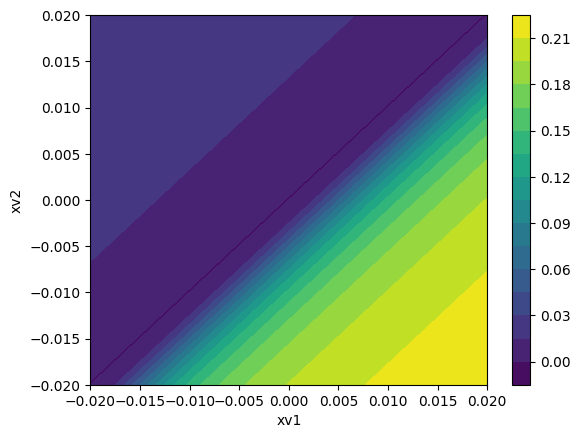

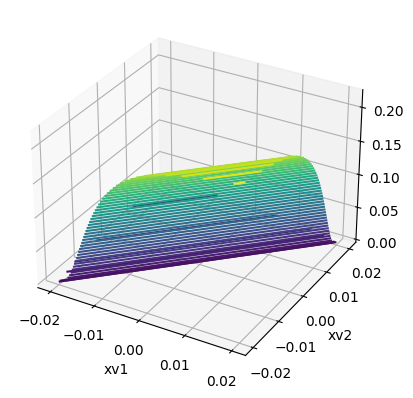

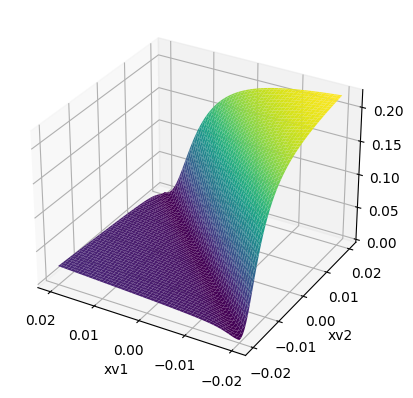

In [ ]:
rng = 0.02

x = np.linspace(- rng, rng, 100)
y = np.linspace(- rng, rng, 100)
X, Y = np.meshgrid(x, y)

XY = np.concatenate([np.expand_dims(X, axis=-1), np.expand_dims(Y, axis=-1)], axis=-1)
XY = np.expand_dims(XY, axis=-1)
XY.shape

En = Easym(torch.from_numpy(XY.astype(np.float32)).clone(),
          norm=None,
          Ws=weight_s1[0].T,
          Wc=weight_c1[0].T,
          Ws2=weight_s2[0].T,
          Wc2=weight_c2[0].T,
          dim_s=-1,
          dim_c=-2,
          )

#plt.contour(X, Y, En)
plt.contourf(X, Y, En, 20, cmap='viridis')
plt.colorbar()
plt.xlabel('xv1')
plt.ylabel('xv2')
plt.show()


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.contour3D(X, Y, En, 50, cmap='viridis')
ax.set_xlabel('xv1')
ax.set_ylabel('xv2')
plt.show()


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.invert_xaxis()
surf = ax.plot_surface(X, Y, En.T, cmap='viridis', linewidth=0)
ax.set_xlabel('xv1')
ax.set_ylabel('xv2')
fig.show()

## NDSolve: larger num of neurons

### Symmetric case

In [ ]:
# sample weights

n_sample = 1

B = 10
S = 4; C = 8  # S=N_vs, C=N_vc
Ns = 20; Nc = 160

r_s1 = 1.0; r_c1 = 2.5
r_s2 = 0.0; r_c2 = 0.0

weight_s1 = _sample_spherical(npoints=n_sample, ndim=S*Ns, radius=r_s1).T.reshape(n_sample,S,Ns)
weight_c1 = _sample_spherical(npoints=n_sample, ndim=C*Nc, radius=r_c1).T.reshape(n_sample,C,Nc)

weight_s2 = _sample_spherical(npoints=n_sample, ndim=Ns*S, radius=r_s2).T.reshape(n_sample,Ns,S)
weight_c2 = _sample_spherical(npoints=n_sample, ndim=Nc*C, radius=r_c2).T.reshape(n_sample,Nc,C)

print(weight_s1, weight_s1.shape)  # (B, S, Ns)
#print(weight_s2, weight_s2.shape)

tensor([[[-0.0022,  0.1518,  0.0645, -0.0399, -0.0057,  0.2599, -0.0047,
           0.1479, -0.0180, -0.0730, -0.1154,  0.0501,  0.1628, -0.0879,
           0.0204, -0.0138, -0.1463, -0.1201, -0.1381,  0.0280],
         [-0.0161,  0.0659,  0.1757, -0.0859,  0.2699,  0.0679,  0.0746,
          -0.1271, -0.0268, -0.0800,  0.0661,  0.0687,  0.1517,  0.0944,
          -0.0563,  0.0665, -0.0222,  0.0272, -0.1564, -0.1727],
         [ 0.0932,  0.0330, -0.0729, -0.1784, -0.2226, -0.1579,  0.1252,
           0.0249, -0.2274,  0.0828, -0.0054,  0.0029,  0.0213, -0.0413,
          -0.0116,  0.0515,  0.1538, -0.0961, -0.0440,  0.0789],
         [ 0.2916,  0.0440,  0.0852, -0.0661,  0.2017,  0.0769,  0.1926,
          -0.0690, -0.0385, -0.0884,  0.1582,  0.1474, -0.0047, -0.1313,
           0.0564,  0.0585,  0.0007,  0.0163, -0.0385,  0.0740]]]) torch.Size([1, 4, 20])


torch.Size([20000, 10, 4, 8])
torch.Size([20000, 4])


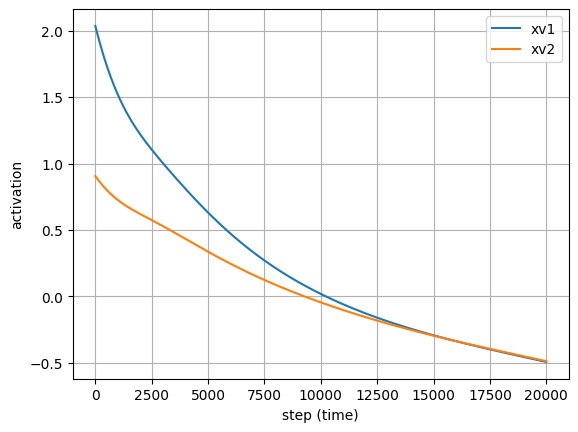

(xv1[t=-1], xv2[t=-1]) = tensor(-0.4932) tensor(-0.4876)


In [ ]:
# solve the dynamical eq

mixerblock = pMixerBlock(seq_len=S,
                         dim=C,
                         weight1s=weight_s1[0],
                         weight2s=weight_s2[0],
                         weight1c=weight_c1[0],
                         weight2c=weight_c2[0],
                         )

def asymmixer(t, x):
    return mixerblock(x)


x0_mean = min(r_s1, r_s2, r_c1, r_c2)
x0_std  = max(r_s1, r_s2, r_c1, r_c2)

x0 = torch.normal(mean=x0_mean, std=x0_std, size=(B, S, C))
t = torch.linspace(0,10,20000)
sol = odeint(asymmixer, x0, t)
print(sol.shape)  # (t, B, S, C)

out = sol[:, 0, :, 0]
print(out.shape)  # (t, S)


plt.plot(out[:, 0], label='xv1')
plt.plot(out[:, 1], label='xv2')
plt.xlabel("step (time)")
plt.ylabel("activation")
plt.grid()
plt.legend()
plt.show()

print('(xv1[t=-1], xv2[t=-1]) =', out[-1][0], out[-1][1])

torch.Size([20000, 10])


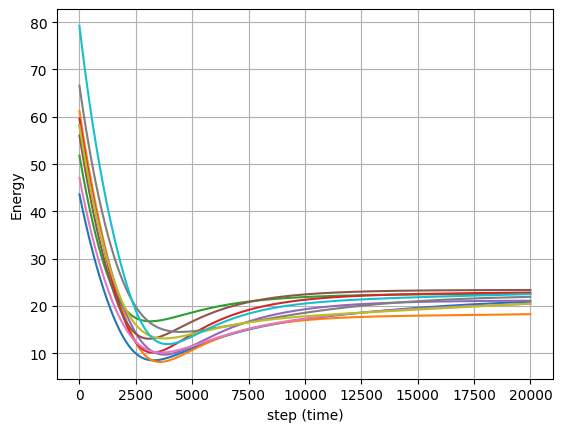

tensor([20.9073, 18.2898, 22.6181, 22.8627, 21.1427, 23.4055, 20.4793, 21.9473,
        20.5328, 22.5231])


In [ ]:
# plot energies along the trajectory

E_t = Easym(sol,
            norm=None,
            Ws=weight_s1[0].T,
            Wc=weight_c1[0].T,
            Ws2=weight_s2[0].T,
            Wc2=weight_c2[0].T,
            dim_s=-1,
            dim_c=-2,
            )
print(E_t.shape)  # (t, B)


for en in E_t.T:
    plt.plot(en)
plt.xlabel("step (time)")
plt.ylabel("Energy")
plt.grid()
plt.show()

print(E_t[-1])

### Asymmetric case

In [ ]:
# sample weights

n_sample = 1

B = 10
S = 4; C = 8  # S=N_vs, C=N_vc
Ns = 20; Nc = 160

r_s1 = 1.0; r_c1 = 2.5
r_s2 = 1.5; r_c2 = 4.0

weight_s1 = _sample_spherical(npoints=n_sample, ndim=S*Ns, radius=r_s1).T.reshape(n_sample,S,Ns)
weight_c1 = _sample_spherical(npoints=n_sample, ndim=C*Nc, radius=r_c1).T.reshape(n_sample,C,Nc)

weight_s2 = _sample_spherical(npoints=n_sample, ndim=Ns*S, radius=r_s2).T.reshape(n_sample,Ns,S)
weight_c2 = _sample_spherical(npoints=n_sample, ndim=Nc*C, radius=r_c2).T.reshape(n_sample,Nc,C)

print(weight_s1, weight_s1.shape)  # (B, S, Ns)
#print(weight_s2, weight_s2.shape)

tensor([[[ 0.1893,  0.1166, -0.1201, -0.0583, -0.2009, -0.0749, -0.0915,
           0.0860, -0.3388,  0.1742,  0.1776, -0.1677, -0.0836, -0.0092,
           0.1983, -0.0600,  0.0647,  0.0176, -0.0682, -0.0354],
         [ 0.0204, -0.0847,  0.0795, -0.1945,  0.0941,  0.1016,  0.0813,
          -0.0791,  0.0032,  0.0258,  0.1021, -0.0723,  0.0880,  0.0214,
           0.0690,  0.0630,  0.1642,  0.0200,  0.0590, -0.0854],
         [-0.0263, -0.0797, -0.0520,  0.2448,  0.0830, -0.0896,  0.0096,
          -0.0249, -0.0551, -0.0728, -0.0416, -0.0309,  0.0346,  0.0122,
          -0.1008, -0.0736,  0.0245, -0.0634,  0.0031, -0.0707],
         [ 0.1622,  0.0082,  0.1644, -0.1426,  0.1100,  0.0176,  0.0390,
           0.0828, -0.0169,  0.0095, -0.0463, -0.0226,  0.0515,  0.2470,
          -0.0766,  0.2961, -0.0955,  0.2036,  0.1493,  0.0096]]]) torch.Size([1, 4, 20])


torch.Size([100000, 10, 4, 8])
torch.Size([100000, 4])


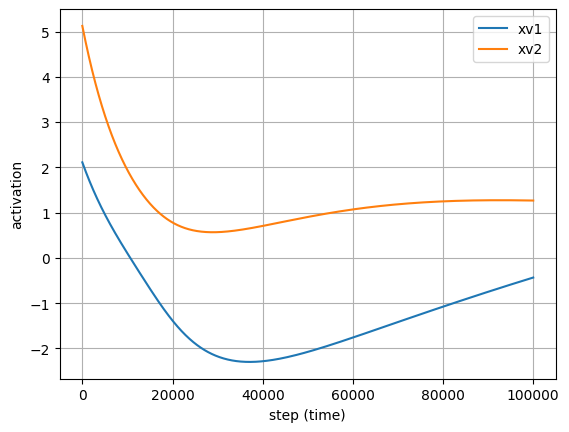

(xv1[t=-1], xv2[t=-1]) = tensor(-0.4340) tensor(1.2667)


In [ ]:
# solve the dynamical eq

mixerblock = pMixerBlock(seq_len=S,
                         dim=C,
                         weight1s=weight_s1[0],
                         weight2s=weight_s2[0],
                         weight1c=weight_c1[0],
                         weight2c=weight_c2[0],
                         )

def asymmixer(t, x):
    return mixerblock(x)


x0_mean = min(r_s1, r_s2, r_c1, r_c2)
x0_std  = max(r_s1, r_s2, r_c1, r_c2)

x0 = torch.normal(mean=x0_mean, std=x0_std, size=(B, S, C))
t = torch.linspace(0,10,100000)
sol = odeint(asymmixer, x0, t)
print(sol.shape)  # (t, B, S, C)

out = sol[:, 0, :, 0]
print(out.shape)  # (t, S)


plt.plot(out[:, 0], label='xv1')
plt.plot(out[:, 1], label='xv2')
plt.xlabel("step (time)")
plt.ylabel("activation")
plt.grid()
plt.legend()
plt.show()

print('(xv1[t=-1], xv2[t=-1]) =', out[-1][0], out[-1][1])

torch.Size([100000, 10])


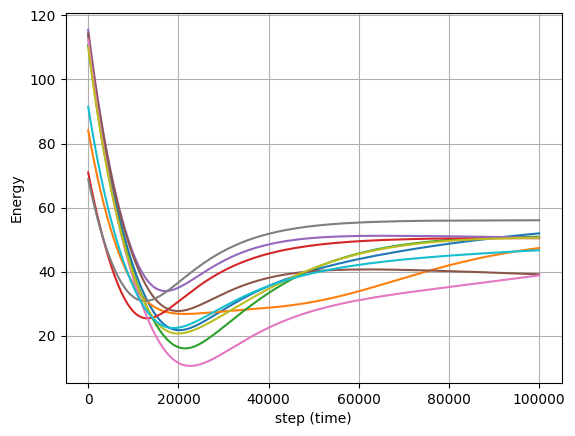

tensor([51.9606, 47.3967, 50.9215, 50.4490, 50.6404, 39.1756, 38.8579, 56.0466,
        50.5903, 46.6945])


In [ ]:
# plot energies along the trajectory

E_t = Easym(sol,
            norm=None,
            Ws=weight_s1[0].T,
            Wc=weight_c1[0].T,
            Ws2=weight_s2[0].T,
            Wc2=weight_c2[0].T,
            dim_s=-1,
            dim_c=-2,
            )
print(E_t.shape)  # (t, B)


for en in E_t.T:
    plt.plot(en)
plt.xlabel("step (time)")
plt.ylabel("Energy")
plt.grid()
plt.show()

print(E_t[-1])